---
title: Comparing HDBSCAN classification statistically
subtitle: Is there any statistical difference between classifications?
author: Murthadza Aznam
date: '2023-01-12'
---

In [82]:
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

## 0. Getting the Data

### 0.1 Source

This notebook will make use of classifications made by [Chen, Bo Han et. al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.1227C/abstract) and parameters calculated by [Hashimoto, Tetsuya et. al. (2022)](https://academic.oup.com/mnras/article/511/2/1961/6507586).

In [76]:
from pathlib import Path

chen2022 = pd.read_csv(Path('..', 'data', 'raw', 'external', 'chen2022_classification.csv'))
hashimoto2022 = pd.read_csv(Path('..', 'data', 'raw', 'external', 'Hashimoto2022_chimefrbcat1.csv'))

data = pd.merge(chen2022[['tns_name', 'group']], hashimoto2022, on='tns_name')
data

,tns_name,group,previous_name,repeater_name,ra,ra_err,ra_notes,dec,dec_err,dec_notes,...,weight_fluence_error_m,weight,weight_error_p,weight_error_m,weighted_logrhoA,weighted_logrhoA_error_p,weighted_logrhoA_error_m,weighted_logrhoB,weighted_logrhoB_error_p,weighted_logrhoB_error_m
0,FRB20180725A,repeater_cluster_1,180725.J0613+67,-9999,93.42,0.04,-9999,67.10,0.20,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FRB20180727A,other_cluster_6,180727.J1311+26,-9999,197.70,0.10,-9999,26.40,0.30,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FRB20180729A,other_cluster_3,180729.J1316+55,-9999,199.40,0.10,-9999,55.58,0.08,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FRB20180729B,repeater_cluster_1,180729.J0558+56,-9999,89.90,0.30,-9999,56.50,0.20,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FRB20180730A,other_cluster_5,180730.J0353+87,-9999,57.39,0.03,-9999,87.20,0.20,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,FRB20190701A,other_cluster_1,-9999,-9999,277.50,0.20,-9999,59.00,0.20,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785,FRB20190701B,other_cluster_5,-9999,-9999,302.90,0.20,-9999,80.20,0.20,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
786,FRB20190701C,repeater_cluster_3,-9999,-9999,96.40,0.20,-9999,81.60,0.30,-9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
787,FRB20190701D,other_cluster_3,-9999,-9999,112.10,0.20,-9999,66.70,0.20,-9999,...,0.000649,1.361506,0.574701,0.206776,0.813142,0.485293,0.109293,0.894742,0.25519,0.19035


## 1. Preprocessing

### 1.1 Calculating Parameters
#### 1.1.1 Intrinsic Width
The observed width is easily affected by dispersion, therefore we need to introduce the intrinsic width to study the pulse width more accurately. The intrinsic width is estimated by equation:
$$
t_i = \sqrt{t^2_\text{obs} − t^2_\text{DM} − t^2_s}
$$ {#eq-intrinsic-width}
In the above formula, $t_i(t_\text{obs})$ is the intrinsic width (observed width), with $t_s$ being the sampling time that depends on the instrument, and $t_\text{DM}$ is the dispersion smearing time-scale as calculated in the following: 
$$
t_\text{DM} = 8.3 \times 10^{−3} \text{DM}\frac{\Delta ν_\text{MHz}}{ν^3_\text{GHz}} ms,
$$ {#eq-dispersion-smearing-time-scale}
where DM is the dispersion measure, $\Delta ν_\text{MHz}$ is the channel bandwidth in the unit of MHz, and $ν_\text{GHz}$ is the central frequency in the unit of GHz. 
Therefore, the pulse width in the following text represents the intrinsic width.


### 1.2 Choosing Parameters
- intrinsic width (`width_fb`)^[`width_fitb` is the intrinsic width of the pulse(The CHIME/FRB Collaboration 2021 doi:10.3847/1538-4365/ac33ab)]
- radio luminosity
- fluence (`fluence`)
- flux (`flux`)
- log rest-frame intrinsic duration (`logsubw_int_rest`)
- radio energy in the logarithmic scale integrated over 400 MHz (`logE_rest_400`)
- highest frequency (`high_freq`)
- lowest frequenc (`low_freq`)
- peak frequency (`peak_freq`)

In [77]:
data['diff_freq'] = data['high_freq'] - data['low_freq']

In [78]:
identifier_params = [
    'tns_name',
    'group'
]
selected_params = [
    'logsubw_int_rest',
    'logE_rest_400',
    'high_freq',
    'low_freq',
    'peak_freq',
    'flux',
    'fluence',
    'width_fitb',
    'diff_freq'
]
data = data[[*identifier_params, *selected_params]]
data

,tns_name,group,logsubw_int_rest,logE_rest_400,high_freq,low_freq,peak_freq,flux,fluence,width_fitb,diff_freq
0,FRB20180725A,repeater_cluster_1,-0.748199,40.208078,760.1,485.3,607.4,2.0,4.0,0.00030,274.8
1,FRB20180727A,other_cluster_6,-0.073706,39.791080,800.2,400.2,493.3,0.6,2.3,0.00140,400.0
2,FRB20180729A,other_cluster_3,-0.948762,38.880719,692.7,400.2,525.6,12.0,20.0,0.00010,292.5
3,FRB20180729B,repeater_cluster_1,-0.582195,38.561879,800.2,441.8,657.5,0.9,1.2,0.00031,358.4
4,FRB20180730A,other_cluster_5,-0.592583,41.127444,759.2,400.2,483.5,5.0,30.0,0.00047,359.0
...,...,...,...,...,...,...,...,...,...,...,...
784,FRB20190701A,other_cluster_1,-0.423913,39.639959,800.2,400.2,800.2,1.3,1.7,0.00061,400.0
785,FRB20190701B,other_cluster_5,-0.463004,39.870346,732.8,400.2,471.5,1.1,1.9,0.00060,332.6
786,FRB20190701C,repeater_cluster_3,-0.148206,40.362724,495.5,402.2,446.4,0.9,2.0,0.00140,93.3
787,FRB20190701D,other_cluster_3,-0.141426,40.835803,651.8,400.2,467.6,1.3,9.0,0.00140,251.6


In [108]:
from itertools import combinations
from scipy.stats import mannwhitneyu

mix_match = pd.DataFrame([*combinations(data['group'].unique(), 2)], columns=['first', 'second'])
mix_match['mww'] = mannwhitneyu(data[data['group'] == mix_match['first']]['width_fitb'], data[data['group']==mix_match['second']]['width_fitb'])
mix_match

ValueError: Can only compare identically-labeled Series objects

In [126]:
for idx, (first, second) in enumerate(zip(mix_match['first'], mix_match['second'])):
    result = mannwhitneyu(data[data['group'] == first]['width_fitb'], data[data['group'] == second]['width_fitb'])
    # print(result.__dir__())
    mix_match.loc[idx, ['mww_width']] = result.pvalue
# mix_match.loc[:,['first']].values[0]

In [127]:
mix_match

,first,second,mww_width
0,repeater_cluster_1,other_cluster_6,0.009313
1,repeater_cluster_1,other_cluster_3,0.000323
2,repeater_cluster_1,other_cluster_5,0.034013
3,repeater_cluster_1,other_cluster_2,0.021257
4,repeater_cluster_1,other_cluster_1,0.368829
5,repeater_cluster_1,repeater_cluster_3,0.201234
6,repeater_cluster_1,other_cluster_4,0.110173
7,repeater_cluster_1,repeater_cluster_2,0.014269
8,other_cluster_6,other_cluster_3,0.070644
9,other_cluster_6,other_cluster_5,0.649525


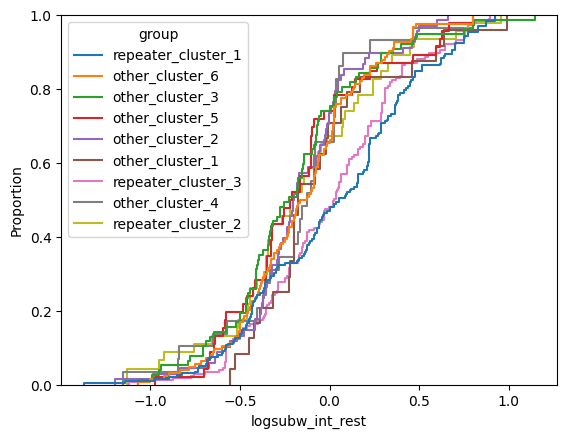

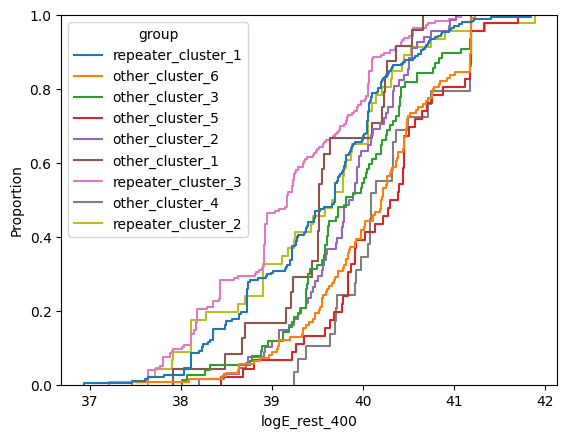

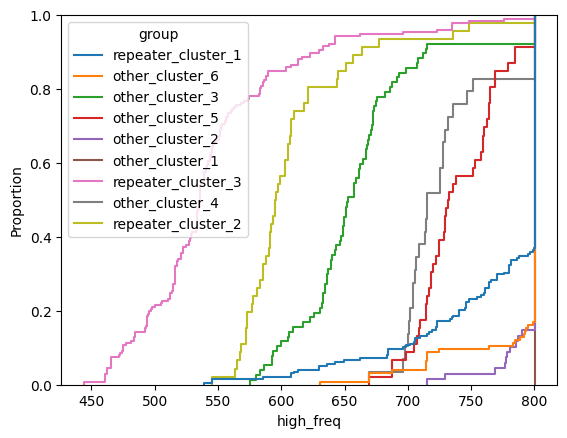

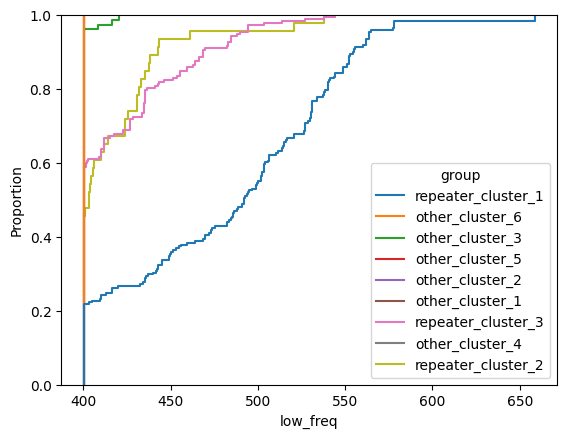

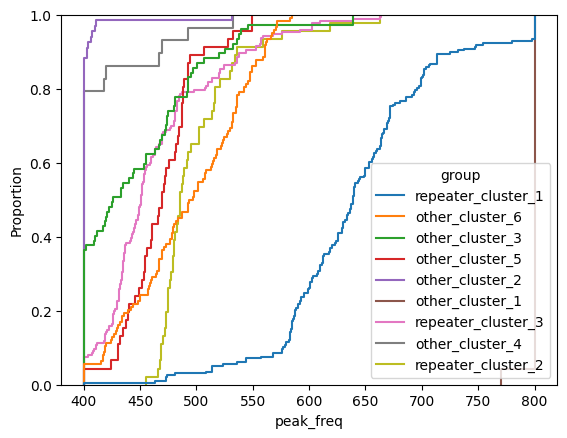

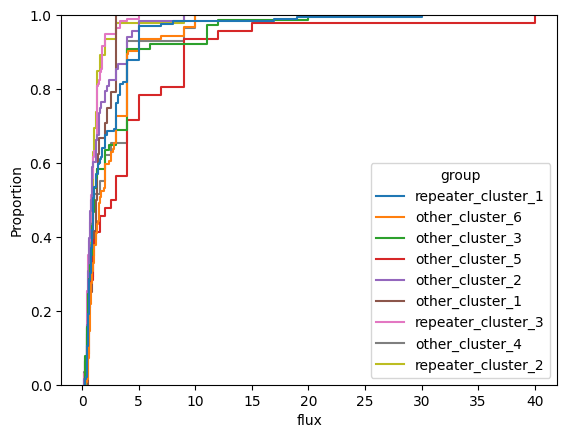

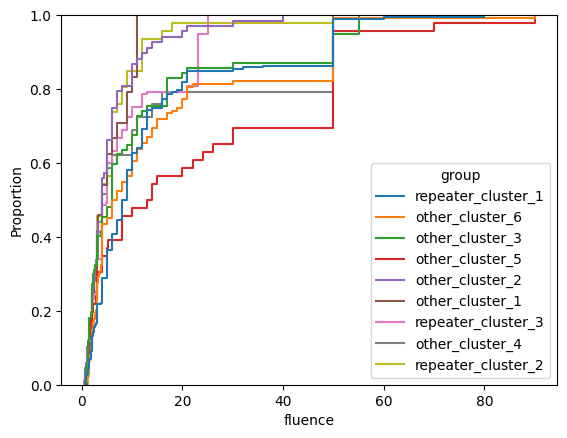

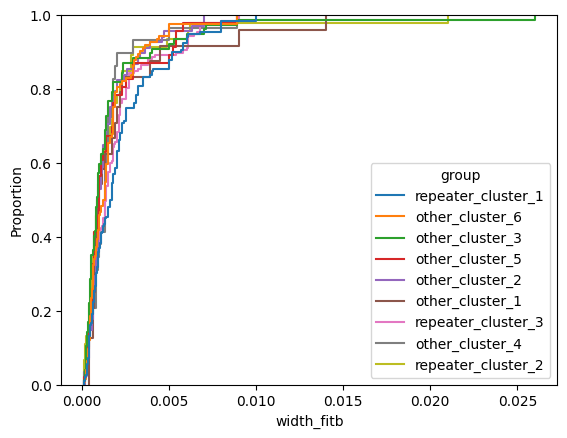

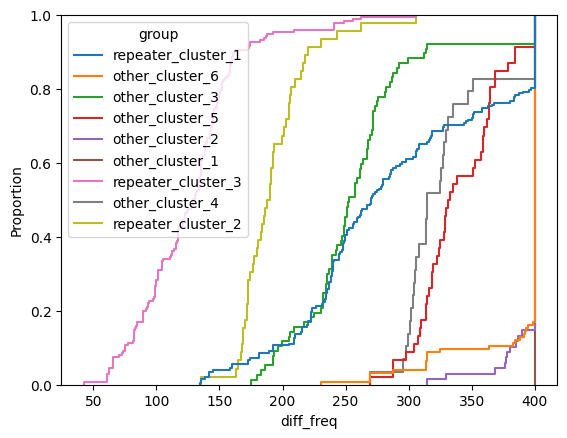

In [80]:
for param in selected_params:
    sns.ecdfplot(data, x=param, hue='group')
    plt.show()

C:\Users\LENOVO\.pyenv\pyenv-win\versions\3.8.10\lib\random.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12464\293886728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['classification'] = 'Chen et. al (2022)'


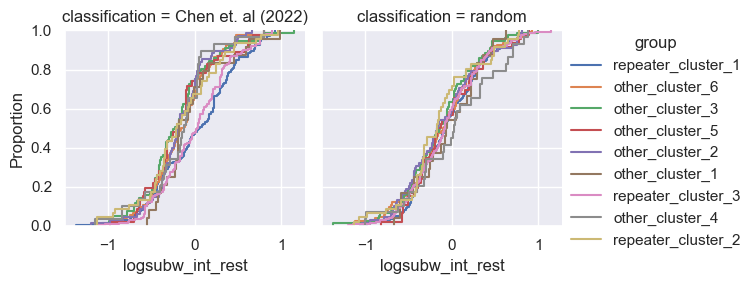

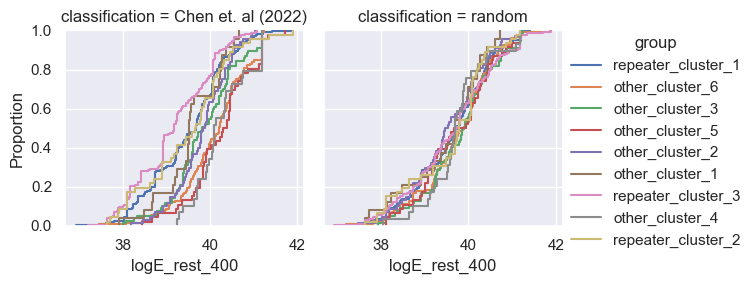

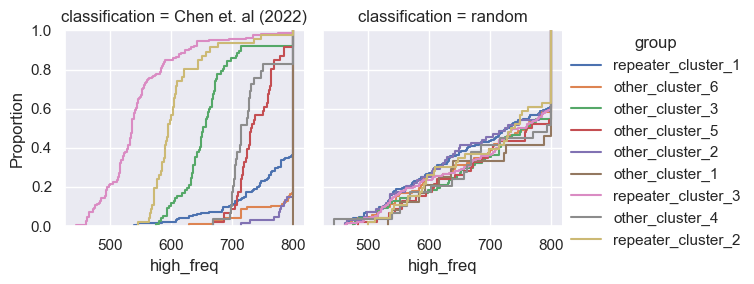

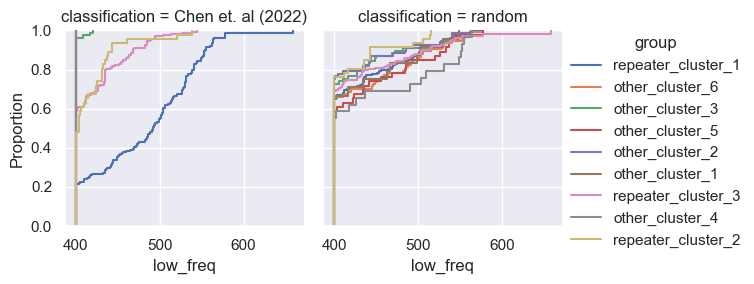

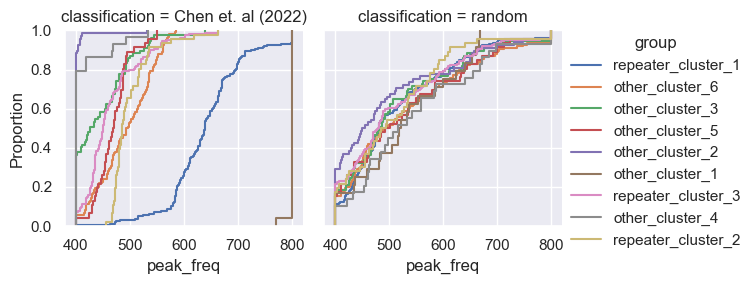

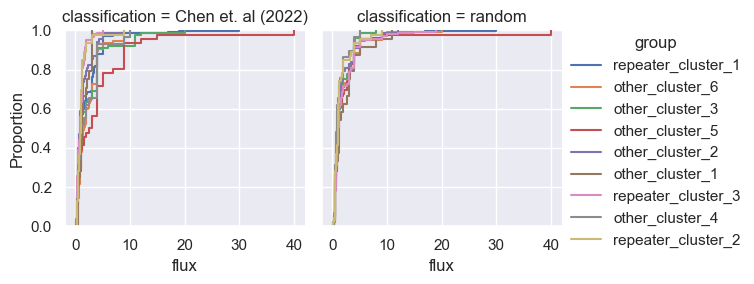

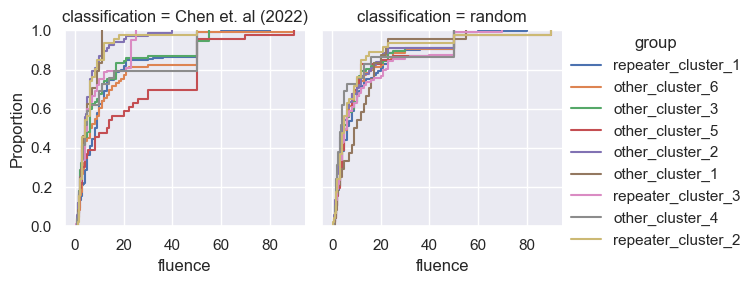

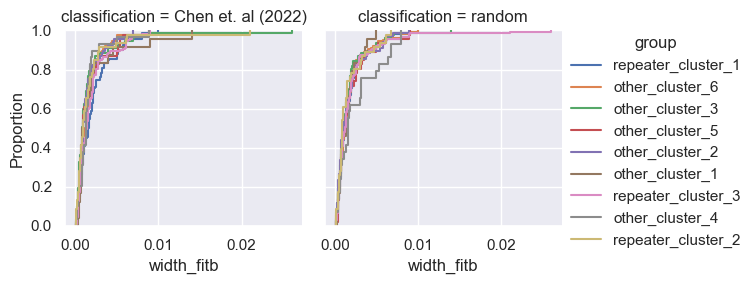

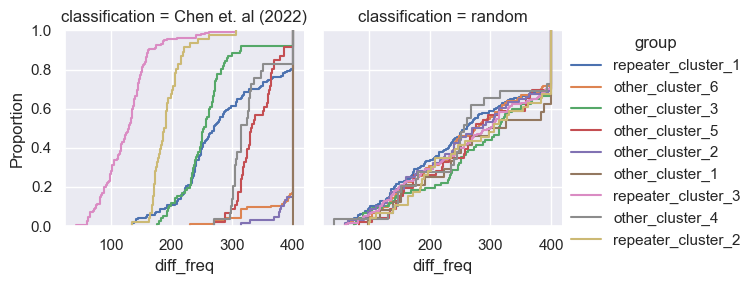

In [85]:
# Label randomly

import random

control = data.copy()
random.shuffle(control['group'])
data['classification'] = 'Chen et. al (2022)'
control['classification'] = 'random'

for param in selected_params:
    g = sns.FacetGrid(pd.concat([data, control]), col='classification', hue='group')
    g.map(sns.ecdfplot, param)
    g.add_legend()
    plt.show()